In [1]:
import tensorflow as tf
import numpy as np
from helpers import pre_process_input_data, convert_tweets_to_bert_embedding, generate_transfer_learn_classifier,generate_fine_tune_model,pre_process_bert_inputs,plot_history #See end of notebook for implementation of these functions
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.layers import Layer

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

[2.0 points] Give an overview of the dataset you have chosen to use.

What is the classification task. Is this multi-task? Explain.
What is the feature data? Who collected the data? Why? When? Is the data multi-modal?
What evaluation criteria will you be using and why? 

[2.0 points] Describe the foundational model that you will be using to transfer learn from. What tasks was this foundational model trained upon? Explain if the new task is within the same domain, across domains, etc

[1.0 points] Split the data into training and testing. Be sure to explain how you performed this operation and why you think it is reasonable to split this particular dataset this way. For multi-task datasets, be sure to explain if it is appropriate to stratify within each task. If the dataset is already split for you, explain how the split was achieved and how it is stratified.

In [2]:
TWEET_FILEPATH = '/mnt/c/Users/alexs/ML/data/concept_net/tweets.csv'
raw_tweet_data = pre_process_input_data(TWEET_FILEPATH,num_samples=150000) #Grab 250,000 of each class (positive and negative sentiment)
raw_tweet_data.head()

,target,text
574913,0,@peterfacinelli i'm trying really hard to win ...
262269,0,damn im missing all of this but i taped it.
3878,0,"Did not sleep well at all, and have a very unh..."
736702,0,Day of unpacking
308513,0,i wanna talk wit sum1


In [3]:
raw_tweet_data.groupby('target').count()

,text
target,
0,150000
1,150000


In [4]:
train_data,test_data,train_targets,test_targets = train_test_split(raw_tweet_data['text'].to_numpy(),raw_tweet_data['target'].to_numpy(),test_size=0.2)
print(f"""
    train_data shape: {train_data.shape}
    train_targets shape: {train_targets.shape}
    test_data shape: {test_data.shape}
    test_targets shape: {test_targets.shape}
      """)


    train_data shape: (240000,)
    train_targets shape: (240000,)
    test_data shape: (60000,)
    test_targets shape: (60000,)
      


TODO: Talk about why we split the data this way. Talk about binary clasification whatever yada yada

In [5]:
# np.unique(test_targets,return_counts=True) #They are evenly split
# np.unique(train_targets,return_counts=True)

# Model From Scratch

[2.0 points] Train a model from scratch to perform the classification task (this does NOT need to be a transformer). That is, do not use transfer learning for the classification task. Verify the model converges (even if the model is overfit). This does NOT need to mirror the foundational model. This model may be far less computational to train.

In [6]:
def clean_tweet(tweet):
    # Remove any non-alphabetic characters except basic punctuation
    tweet = re.sub(r"[^a-zA-Z0-9.,'!? ]", '', tweet)
    # Remove any excess whitespace
    tweet = re.sub(r"\s+", ' ', tweet).strip()
    return tweet


In [7]:
X_train = np.array([clean_tweet(t) for t in train_data])
X_test = np.array([clean_tweet(t) for t in test_data])

y_train = train_targets.copy()
y_test = test_targets.copy()

In [8]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = np.max([len(tweet) for tweet in X_train]) # maximum number of words in a tweet

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X_train)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(X_train)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_ART_LEN)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_ART_LEN)


#y_ohe = keras.utils.to_categorical(y_train, num_classes=2)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_train.shape)
print(np.max(X))

Found 198550 unique tokens. Distilled to 198550 top words.
Shape of data tensor: (240000, 169)
Shape of label tensor: (240000,)
198550


In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dropout, GlobalAveragePooling1D
from tensorflow.keras.layers import Subtract, Concatenate
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential

# Parameters for embedding layer
VOCAB_SIZE = len(word_index) + 1  # Add 1 for padding
EMBED_SIZE = 300  # You can change this size according to your preference

# Create model
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_ART_LEN))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
# model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=5))
model.add(Flatten())
model.add(Dropout(0.5))
# model.add(Dense(32,activation='sigmoid'))
# model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile model
#make learning rate in adam optimizer smaller
adam_optimizer = keras.optimizers.Adam(learning_rate=1e-5)

#early stopping from val_loss
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,min_delta=0.001)

model.compile(optimizer= adam_optimizer, loss='mse', metrics=['accuracy'])

# Print summary
model.summary()

# Train the model
embed_hist = model.fit(X, y_train, epochs=25, batch_size=512, validation_data=(X_test, y_test), callbacks=early_stopping)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

# Once the model is trained, you can retrieve the learned embedding weights
embedding_weights = model.layers[0].get_weights()[0]
print("Embedding weights shape:", embedding_weights.shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 169, 300)          59565300  
                                                                 
 conv1d (Conv1D)             (None, 167, 128)          115328    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 33, 128)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4224)              0         
                                                                 
 dropout_37 (Dropout)        (None, 4224)              0         
                                                                 
 dense (Dense)               (None, 1)                 4225      
                                                        

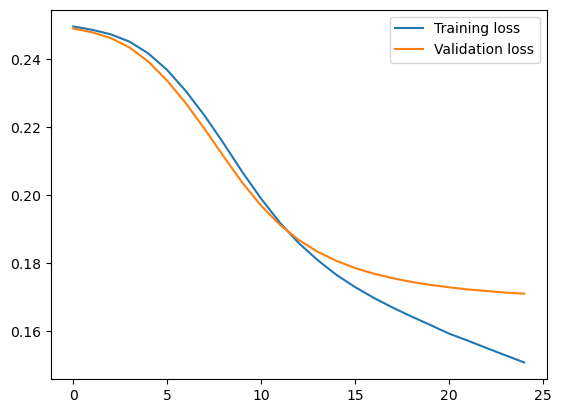

In [10]:
plot_history(embed_hist.history,'loss') #Plot embedding loss as its training

In [11]:
sample_preds = model(X_test[0:15])
for pred,txt in zip(sample_preds,test_data[0:15]):
    print(f'Prediction: {(pred[0])} | Text: {txt}')

Prediction: 0.8920257091522217 | Text: @csharpzealot hehehe you're giving me ideas 
Prediction: 0.546600341796875 | Text: Now is 3.43pm and faci haven finish his lesson...always liddat... 
Prediction: 0.08219126611948013 | Text: Seeing land of the lost cuz all the hangovers are sold out 
Prediction: 0.6064983606338501 | Text: @MrNateJackson I interjected your name into my Facebook status...I was runnin' out of room on twitter, sorry 
Prediction: 0.780858039855957 | Text: @nicknye  im not a rap fan but have met Mason before &amp; appreciate his ministry. I'll be praying for his church &amp; the restoration of Ambas
Prediction: 0.26082977652549744 | Text: Right, I'm at work for 7 hours... Anyone wanna tweet chat? 
Prediction: 0.7909603714942932 | Text: New week...  work in progresssssssssss
Prediction: 0.8234612345695496 | Text: Finished watching Underworld: The Rise of the Lycans 
Prediction: 0.004607122391462326 | Text: mommaTANIS is feeling horrible and she feels horrible...gah! i nee

In [12]:
y_hat_from_scratch = np.round(model.predict(X_test))

1875/1875 [==============================] - 2s 960us/step


In [13]:
y_hat_from_scratch

array([[1.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

[2.0 points] Train a model by transfer learning from your foundational model. Verify that the new model converges. You only need to train a model using the bottleneck features for this step. 

# Bottleneck Transfer Learning

In [14]:
mdl = generate_transfer_learn_classifier()
mdl.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 768)]       0         
                                                                 
 dense_1 (Dense)             (None, None, 128)         98432     
                                                                 
 dropout_38 (Dropout)        (None, None, 128)         0         
                                                                 
 dense_2 (Dense)             (None, None, 32)          4128      
                                                                 
 dense_3 (Dense)             (None, None, 1)           33        
                                                                 
Total params: 102,593
Trainable params: 102,593
Non-trainable params: 0
_________________________________________________________________


In [15]:
tf.keras.backend.clear_session()
X_train_bottleneck = convert_tweets_to_bert_embedding(train_data,batch_size=500) 
X_test_bottleneck = convert_tweets_to_bert_embedding(test_data,batch_size=500) 

Grabbing BERT Embeddings with padding to 369 characters


  0%|          | 0/480 [00:00<?, ?it/s]

Grabbing BERT Embeddings with padding to 296 characters


  0%|          | 0/120 [00:00<?, ?it/s]

In [16]:
print(f"""
      X_train shape :{X_train_bottleneck.shape}
      X_test shape :{X_test_bottleneck.shape}
      """)


      X_train shape :(240000, 768)
      X_test shape :(60000, 768)
      


In [17]:
hist = mdl.fit(X_train_bottleneck,train_targets,validation_data=(X_test_bottleneck,test_targets),epochs=100,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15,min_delta=0.001)])

Epoch 1/100
7500/7500 [==============================] - 18s 2ms/step - loss: 0.4826 - accuracy: 0.7689 - val_loss: 0.4557 - val_accuracy: 0.7865
Epoch 2/100
7500/7500 [==============================] - 18s 2ms/step - loss: 0.4614 - accuracy: 0.7822 - val_loss: 0.4501 - val_accuracy: 0.7892
Epoch 3/100
7500/7500 [==============================] - 18s 2ms/step - loss: 0.4545 - accuracy: 0.7861 - val_loss: 0.4654 - val_accuracy: 0.7833
Epoch 4/100
7500/7500 [==============================] - 17s 2ms/step - loss: 0.4504 - accuracy: 0.7886 - val_loss: 0.4552 - val_accuracy: 0.7919
Epoch 5/100
7500/7500 [==============================] - 17s 2ms/step - loss: 0.4469 - accuracy: 0.7907 - val_loss: 0.4532 - val_accuracy: 0.7935
Epoch 6/100
7500/7500 [==============================] - 18s 2ms/step - loss: 0.4442 - accuracy: 0.7929 - val_loss: 0.4486 - val_accuracy: 0.7972
Epoch 7/100
7500/7500 [==============================] - 17s 2ms/step - loss: 0.4428 - accuracy: 0.7928 - val_loss: 0.4534 -

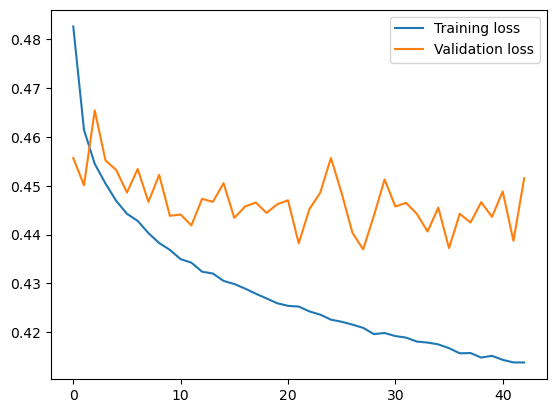

In [18]:
plot_history(hist.history,'loss')

In [19]:
y_hat_bottleneck = np.round(mdl.predict(X_test_bottleneck))


1875/1875 [==============================] - 2s 884us/step


# Fine Tune Network

In [20]:
from helpers import bert_model
from helpers import bert_tokenizer

def generate_base_model():
    
    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="attention_mask")
    token_type_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="token_type_ids")
    for l in bert_model.bert.encoder.layer:
        l.trainable = False
    bert_model.bert.embeddings.trainable = False
    # bert_model.bert.trainable = False
    bert_model.bert.encoder.layer[-1].trainable = True
    # BERT model
    bert_model.bert.pooler.trainable = False
    outputs = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    print(outputs)
    # Extract the last hidden state
    pooled_output = outputs.last_hidden_state[:,0,:]

    # Define model
    model = tf.keras.Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=pooled_output)

    return model
base_model = generate_base_model()

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<KerasTensor: shape=(None, None, 768) dtype=float32 (created by layer 'tf_bert_model')>, pooler_output=<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf_bert_model')>, past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)


In [21]:
base_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf.__operators__.getitem')>

In [22]:

fine_tune_model = tf.keras.Model(inputs=base_model.inputs,outputs=mdl(base_model.output))

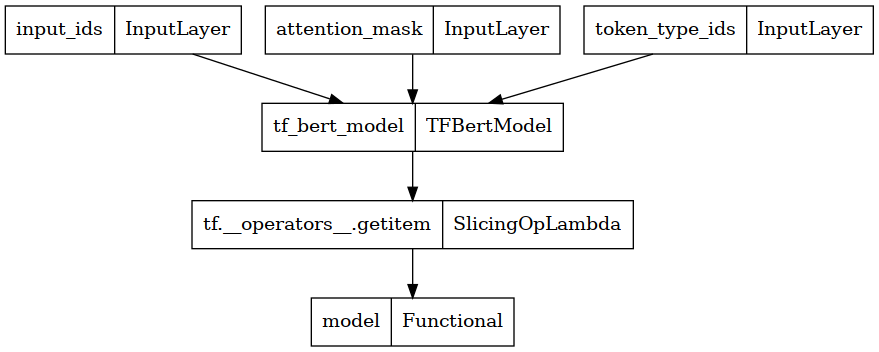

In [23]:
tf.keras.utils.plot_model(fine_tune_model)

In [24]:
fine_tune_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',   

In [25]:
x_train,y_train = pre_process_bert_inputs(train_data,train_targets)
x_test,y_test = pre_process_bert_inputs(test_data,test_targets)

In [26]:
fine_tune_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss = tf.keras.losses.mean_squared_error,
    metrics=['accuracy']
)

In [27]:
fine_tune_hist = fine_tune_model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=5,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,min_delta=0.001)])

Epoch 1/5
7500/7500 [==============================] - 766s 101ms/step - loss: 0.1420 - accuracy: 0.7959 - val_loss: 0.1298 - val_accuracy: 0.8207
Epoch 2/5
7500/7500 [==============================] - 763s 102ms/step - loss: 0.1329 - accuracy: 0.8110 - val_loss: 0.1267 - val_accuracy: 0.8268
Epoch 3/5
7500/7500 [==============================] - 764s 102ms/step - loss: 0.1287 - accuracy: 0.8178 - val_loss: 0.1247 - val_accuracy: 0.8316
Epoch 4/5
7500/7500 [==============================] - 764s 102ms/step - loss: 0.1258 - accuracy: 0.8221 - val_loss: 0.1243 - val_accuracy: 0.8316
Epoch 5/5
7500/7500 [==============================] - 764s 102ms/step - loss: 0.1236 - accuracy: 0.8254 - val_loss: 0.1222 - val_accuracy: 0.8331


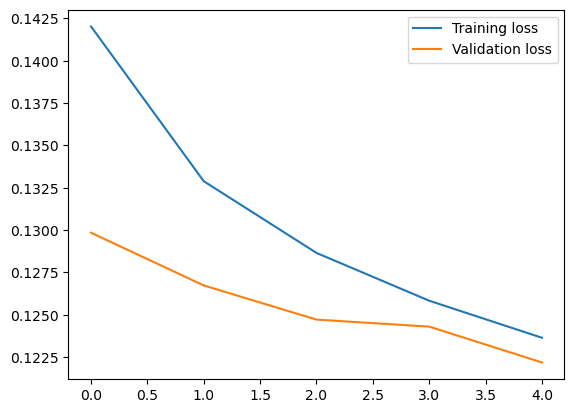

In [28]:
plot_history(fine_tune_hist.history,'loss')

In [29]:
y_hat_fine_tune = np.round(fine_tune_model.predict(x_test))

1875/1875 [==============================] - 99s 52ms/step


In [40]:
from statsmodels.stats.contingency_tables import mcnemar

from_scratch_preds = y_hat_from_scratch.flatten() == test_targets.flatten()
bottleneck_preds =  y_hat_bottleneck.flatten() == test_targets.flatten()
finetune_preds =  y_hat_fine_tune.flatten() == test_targets.flatten()
# transformer_preds =  y_hat_transfromer_from_scratch.flatten() == test_targets.flatten()
# correct_pred3 = np.argmax(yhat_t3, axis=1) == np.argmax(y_test, axis=1)


def calculate_mcnemar(correct1, correct2):
    # Count the number of times each model was correct/incorrect
    n00 = n01 = n10 = n11 = 0
    for i in range(len(correct1)):
        if correct1[i] and correct2[i]:
            n11 += 1
        elif correct1[i] and not correct2[i]:
            n10 += 1
        elif not correct1[i] and correct2[i]:
            n01 += 1
        elif not correct1[i] and not correct2[i]:
            n00 += 1
    
    # Construct the contingency table
    table = [[n11, n10],
             [n01, n00]]
    
    # Perform McNemar's test
    result = mcnemar(table, exact=False, correction=True)  # Use correction for small sample sizes
    return result

# Calculate McNemar's test
# result1_2 = calculate_mcnemar(correct_pred1, correct_pred2)
# result1_3 = calculate_mcnemar(correct_pred1, correct_pred3)
# result2_3 = calculate_mcnemar(correct_pred2, correct_pred3)
res_scratch_bottleneck = calculate_mcnemar(from_scratch_preds,bottleneck_preds)
res_scratch_finetune = calculate_mcnemar(from_scratch_preds,finetune_preds)
res_finetune_bottleneck = calculate_mcnemar(finetune_preds,bottleneck_preds)


print(f'From Scratch(CNN) Vs. Bottleneck (Bert): stat={res_scratch_bottleneck.statistic}, p-value={res_scratch_bottleneck.pvalue}')
print(f'From Scratch(CNN) Vs. FineTune (Bert): stat={res_scratch_finetune.statistic}, p-value={res_scratch_finetune.pvalue}')
print(f'Bottleneck (Bert) Vs. FineTune (Bert): stat={res_finetune_bottleneck.statistic}, p-value={res_finetune_bottleneck.pvalue}')


From Scratch(CNN) Vs. Bottleneck (Bert): stat=875.0921309343161, p-value=2.550213185774605e-192
From Scratch(CNN) Vs. FineTune (Bert): stat=2046.2767920511, p-value=0.0
Bottleneck (Bert) Vs. FineTune (Bert): stat=450.13304498269895, p-value=6.747786316450042e-100


# Additional Information

## Transformer from Scratch

In [30]:
EMBED_SIZE = 300
print('Found %s word vectors.' % len(embedding_weights))

# Now fill in the matrix using the ordering from the keras word tokenizer
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embedding_weights[i]  # Use the learned embeddings
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        found_words += 1

print("Embedding Shape:", embedding_matrix.shape, "\n",
      "Total words found:", found_words, "\n",
      "Percentage:", 100 * found_words / embedding_matrix.shape[0])

Found 198551 word vectors.
Embedding Shape: (198551, 300) 
 Total words found: 198550 
 Percentage: 99.99949635106346


In [31]:
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embed_dim)

        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # apply the layers as needed (similar to PyTorch)

        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key)
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)

        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)

        # apply dropout if training
        out1 = self.dropout1(out1, training=training)

        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)

        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2

class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings
        # one for processing the tokens (words)
        self.token_emb = Embedding(input_dim=vocab_size,
                                   output_dim=embed_dim)
        # another embedding for processing the position
        self.pos_emb = Embedding(input_dim=maxlen,
                                 output_dim=embed_dim)

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

class CustomTokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings
        # one for processing the tokens (words)
        self.token_emb = Embedding(len(word_index)+1,
                                   EMBED_SIZE,
                                   weights=[embedding_matrix],
                                   input_length=MAX_ART_LEN)
        self.token_emb.trainable=False
        
        # another embedding for processing the position
        self.pos_emb = Embedding(MAX_ART_LEN,
                                 EMBED_SIZE,
                                 input_length=MAX_ART_LEN,
                                )

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [32]:
embed_dim = 300  # Embedding size for each token
num_heads = 6  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
top_words = 100
NUM_CLASSES =  1

adam_optimizer = tf.optimizers.Adam(learning_rate=1e-5)
inputs = Input(shape=(X_train.shape[1],))
x = CustomTokenAndPositionEmbedding(X_train.shape[1], top_words, embed_dim)(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(NUM_CLASSES, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)
xformer = Model(inputs=inputs, outputs=outputs)
model_xformer = Model(inputs=inputs, outputs=outputs)
print(model_xformer.summary())
xformer.compile(optimizer=adam_optimizer,
                      loss='mse',
                      metrics=['accuracy'])
history = xformer.fit(
    X_train, y_train, batch_size=512, epochs=30,
    validation_data=(X_test, y_test),callbacks=[early_stopping]
)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 169)]             0         
                                                                 
 custom_token_and_position_e  (None, 169, 300)         59616000  
 mbedding (CustomTokenAndPos                                     
 itionEmbedding)                                                 
                                                                 
 transformer_block (Transfor  (None, 169, 300)         2186432   
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 300)               0   

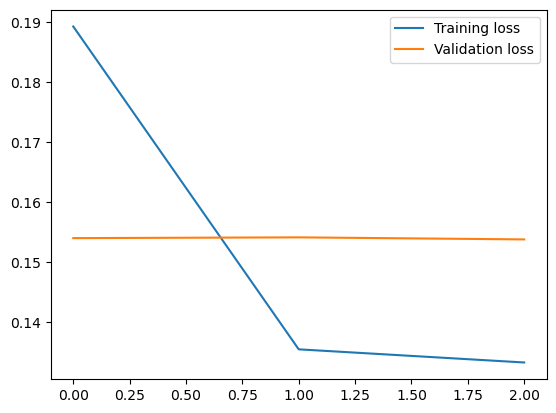

In [33]:
plot_history(history.history,'loss')

In [34]:
y_hat_transfromer_from_scratch = np.round(xformer.predict(X_test))

1875/1875 [==============================] - 5s 2ms/step


In [35]:
# y_hat_transfromer_from_scratch.shape

In [36]:
y_test

<tf.Tensor: shape=(60000,), dtype=int64, numpy=array([1, 0, 0, ..., 0, 0, 1])>

## helpers.py

In [ ]:
"""
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn
from datetime import datetime
from tqdm.auto import tqdm
from transformers import BertTokenizer, TFBertModel

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

def pre_process_input_data(filepath='./data/concept_net/tweets.csv',encoding='cp1252',num_samples=None,random_state=None): #Change encoding if not on windows
    tweets = pd.read_csv(filepath,encoding=encoding,header=None)
    tweets.columns = ['target','id','date','flag','username','text'] #Change column names to things that make sense
    tweets = tweets.drop(columns=['id','date','flag','username']) #Remove unneeded columns from memory

    tweets = tweets.replace({'target':{0:0,4:1}}) #Dataset has only 0=negative sent, 4=positive sent, remappping to 0,1 respectivly
    if num_samples:
        tweets = tweets.groupby('target').sample(num_samples,random_state=random_state)

    return tweets

def convert_tweets_to_bert_embedding(text_arr:np.ndarray,batch_size=500):
        batches = [(i,min(i+batch_size,len(text_arr))) for i in range(0,len(text_arr),batch_size)] #Split into smaller chunks

        # _df = pd.DataFrame()
        max_twt_len = np.max([len(v) for v in text_arr])

        res = []
        print(f'Grabbing BERT Embeddings with padding to {max_twt_len} characters')
        for lower,upper in tqdm(batches):
            chunk = text_arr[lower:upper]
            features = bert_tokenizer(chunk.tolist(),padding='max_length', truncation=True, return_tensors='tf',max_length=max_twt_len)
            features = bert_model(**features).last_hidden_state[:,0,:]
            # chunk['features'] = features.numpy().tolist()
            res.append(features.numpy())
        return np.array(res).reshape(-1,768) # Reshape to output numrows by embedding space

def generate_transfer_learn_classifier():
    inputs = tf.keras.layers.Input(shape=(None,768))

    x = tf.keras.layers.Dense(128,activation = 'relu')(inputs)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(32,activation='relu')(x)
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[inputs],outputs=x)
    model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

    return model

def plot_history(hist,metric,show_val=True):
    plt.plot(hist[f'{metric}'])
    if show_val:
        plt.plot(hist[f'val_{metric}'])
        plt.legend([f'Training {metric}',f'Validation {metric}'])  
    plt.show()

def generate_fine_tune_model():
    
    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="attention_mask")
    token_type_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="token_type_ids")
    for l in bert_model.bert.encoder.layer:
        l.trainable = False
    bert_model.bert.embeddings.trainable = False
    # bert_model.bert.trainable = False
    bert_model.bert.encoder.layer[-1].trainable = True
    # BERT model
    bert_model.bert.pooler.trainable = False
    outputs = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    # Extract the pooled output (CLS token) from BERT
    pooled_output = outputs.pooler_output

    # Add your custom top layer
    dense_layer = tf.keras.layers.Dense(128, activation='relu')(pooled_output)
    dropout_layer = tf.keras.layers.Dropout(0.5)(dense_layer)
    dropout_layer = tf.keras.layers.Dense(32,activation='relu')(dropout_layer)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(dropout_layer)

    # Define model
    model = tf.keras.Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=output_layer)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                loss=tf.losses.binary_crossentropy,
                metrics=['accuracy'])
    return model
def pre_process_bert_inputs(x:np.ndarray,y:np.ndarray):
    sentences = x
    sentiment_values = y  # Example sentiment values: 1 for positive, 0 for negative

    # Tokenize input sentences
    tokenized_inputs = bert_tokenizer(sentences.tolist(), padding=True, truncation=True, return_tensors="tf")

    # Convert sentiment values to TensorFlow tensors
    sentiment_values = tf.convert_to_tensor(sentiment_values)

    # Prepare input data as a dictionary
    input_data = {
        "input_ids": tokenized_inputs["input_ids"],
        "attention_mask": tokenized_inputs["attention_mask"],
        "token_type_ids": tokenized_inputs["token_type_ids"]
    }
    return input_data,sentiment_values

if __name__ == "__main__":
    mdl = generate_fine_tune_model()
    print(mdl.summary())


"""